## Computer Vision Projects : face swapping

In [1]:
import cv2
import mediapipe as mp
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
print(cv2.__version__)
print(mp.__version__)
print(np.__version__)

4.8.0
0.10.5
1.23.4


___

### 1. Swapping two faces of two input images, using hand-defined points

In [3]:
import sys
import numpy as np
import cv2

# Read points from text file
def readPoints(path) :
    # Create an array of points.
    points = [];
    
    # Read points
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(x), int(y)))
    

    return points

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst


# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True


#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        subdiv.insert(p) 
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []        
            
    
    return delaunayTri
        

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    

if __name__ == '__main__' :
    
    # Make sure OpenCV is version 3.0 or above
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

    if int(major_ver) < 3 :
        print >>sys.stderr, 'ERROR: Script needs OpenCV 3.0 or higher'
        sys.exit(1)

    # Read images
    filename1 = 'ted_cruz.jpg'
    filename2 = 'donald_trump.jpg'
    
    img1 = cv2.imread(filename1);
    img2 = cv2.imread(filename2);
    img1Warped = np.copy(img2);    
    
    # Read array of corresponding points
    points1 = readPoints(filename1 + '.txt')
    points2 = readPoints(filename2 + '.txt')    
    
    # Find convex hull
    hull1 = []
    hull2 = []

    hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)
          
    for i in range(0, len(hullIndex)):
        hull1.append(points1[int(hullIndex[i])])
        hull2.append(points2[int(hullIndex[i])])
    
    
    # Find delanauy traingulation for convex hull points
    sizeImg2 = img2.shape    
    rect = (0, 0, sizeImg2[1], sizeImg2[0])
     
    dt = calculateDelaunayTriangles(rect, hull2)
    
    if len(dt) == 0:
        quit()
    
    # Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
        
        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(hull1[dt[i][j]])
            t2.append(hull2[dt[i][j]])
        
        warpTriangle(img1, img1Warped, t1, t2)
    
            
    # Calculate Mask
    hull8U = []
    for i in range(0, len(hull2)):
        hull8U.append((hull2[i][0], hull2[i][1]))
    
    mask = np.zeros(img2.shape, dtype = img2.dtype)  
    
    cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
    
    r = cv2.boundingRect(np.float32([hull2]))    
    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
        
    
    # Clone seamlessly.
    output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)
    
    cv2.imshow("Face Swapped", output)
    cv2.waitKey(0)
    
    cv2.destroyAllWindows()

### 2. Swapping two faces, using mediapipe face mesh detector

#### 2.1 Applying Mediapipe face mesh on webcam

In [1]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

# For webcam input:
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
cap = cv2.VideoCapture(0)
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:
    
      while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Ignoring empty camera frame.")
                # If loading a video, use 'break' instead of 'continue'.
                continue

            # To improve performance, optionally mark the image as not writeable to
            # pass by reference.
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(image)

            # Draw the face mesh annotations on the image.
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            if results.multi_face_landmarks:
                for face_landmarks in results.multi_face_landmarks:
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_TESSELATION,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_tesselation_style())
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_CONTOURS,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_contours_style())
                    mp_drawing.draw_landmarks(
                        image=image,
                        landmark_list=face_landmarks,
                        connections=mp_face_mesh.FACEMESH_IRISES,
                        landmark_drawing_spec=None,
                        connection_drawing_spec=mp_drawing_styles
                        .get_default_face_mesh_iris_connections_style())
                
            # Flip the image horizontally for a selfie-view display.
            cv2.imshow('MediaPipe Face Mesh', cv2.flip(image, 1))
            
            if cv2.waitKey(5) == 27 or cv2.waitKey(5) & 0xFF == ord("q"):
                break
        
cap.release()
cv2.destroyAllWindows()

#### Getting to know the result 

In [5]:
print(results.multi_face_landmarks[0].landmark[0])

x: 0.7465507984161377
y: 0.6099734306335449
z: -0.0344022735953331



In [6]:
x_coords = [landmark.x for landmark in results.multi_face_landmarks[0].landmark]
y_coords = [landmark.y for landmark in results.multi_face_landmarks[0].landmark]

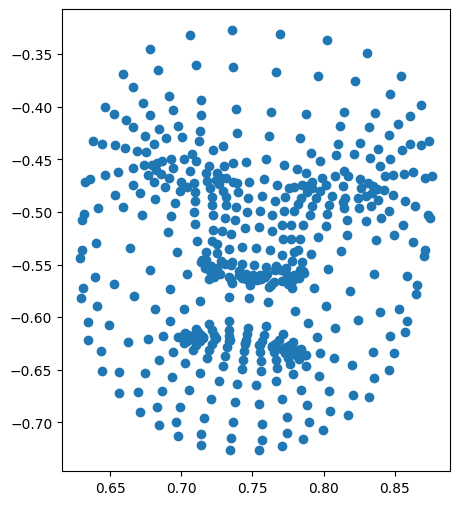

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 6))
plt.scatter(x_coords, [-1*y for y in y_coords])

#### 2.2 Defining functions 

In [8]:
def get_landmark_points(src_image):
    with mp_face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB))
        if not results.multi_face_landmarks:
            return None
        if len(results.multi_face_landmarks) > 1:
            sys.exit("There are too much face landmarks")

        src_face_landmark = results.multi_face_landmarks[0].landmark
        landmark_points = []
        for i in range(468):
            y = int(src_face_landmark[i].y * src_image.shape[0])
            x = int(src_face_landmark[i].x * src_image.shape[1])
            landmark_points.append((x, y))

        return landmark_points


def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index


def get_triangles(convexhull, landmarks_points, np_points):
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indices_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])

        index_pt1 = np.where((np_points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)
        index_pt2 = np.where((np_points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)
        index_pt3 = np.where((np_points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indices_triangles.append(triangle)

    return indices_triangles


def triangulation(triangle_index, landmark_points, img=None):
    tr1_pt1 = landmark_points[triangle_index[0]]
    tr1_pt2 = landmark_points[triangle_index[1]]
    tr1_pt3 = landmark_points[triangle_index[2]]
    triangle = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)

    rect = cv2.boundingRect(triangle)
    (x, y, w, h) = rect

    cropped_triangle = None
    if img is not None:
        cropped_triangle = img[y: y + h, x: x + w]

    cropped_triangle_mask = np.zeros((h, w), np.uint8)

    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_triangle_mask, points, 255)

    return points, cropped_triangle, cropped_triangle_mask, rect


def warp_triangle(rect, points1, points2, src_cropped_triangle, dest_cropped_triangle_mask):
    (x, y, w, h) = rect
    matrix = cv2.getAffineTransform(np.float32(points1), np.float32(points2))
    warped_triangle = cv2.warpAffine(src_cropped_triangle, matrix, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=dest_cropped_triangle_mask)
    return warped_triangle


def add_piece_of_new_face(new_face, rect, warped_triangle):
    (x, y, w, h) = rect
    new_face_rect_area = new_face[y: y + h, x: x + w]
    new_face_rect_area_gray = cv2.cvtColor(new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    new_face_rect_area = cv2.add(new_face_rect_area, warped_triangle)
    new_face[y: y + h, x: x + w] = new_face_rect_area


def swap_new_face(dest_image, dest_image_gray, dest_convexHull, new_face):
    face_mask = np.zeros_like(dest_image_gray)
    head_mask = cv2.fillConvexPoly(face_mask, dest_convexHull, 255)
    face_mask = cv2.bitwise_not(head_mask)

    head_without_face = cv2.bitwise_and(dest_image, dest_image, mask=face_mask)
    result = cv2.add(head_without_face, new_face)

    (x, y, w, h) = cv2.boundingRect(dest_convexHull)
    center_face = (int((x + x + w) / 2), int((y + y + h) / 2))

    return cv2.seamlessClone(result, dest_image, head_mask, center_face, cv2.MIXED_CLONE)


def set_src_image(image):
    global src_image, src_image_gray, src_mask, src_landmark_points, src_np_points, src_convexHull, indices_triangles
    src_image = image
    src_image_gray = cv2.cvtColor(src_image, cv2.COLOR_BGR2GRAY)
    src_mask = np.zeros_like(src_image_gray)

    src_landmark_points = get_landmark_points(src_image)
    src_np_points = np.array(src_landmark_points)
    src_convexHull = cv2.convexHull(src_np_points)
    cv2.fillConvexPoly(src_mask, src_convexHull, 255)

    indices_triangles = get_triangles(convexhull=src_convexHull,
                                                  landmarks_points=src_landmark_points,
                                                  np_points=src_np_points)

#### 2.3 swapping faces of two images

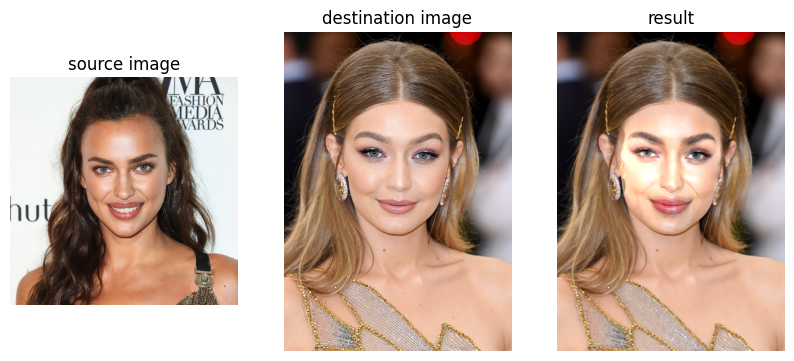

In [9]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import sys


global src_image, src_image_gray, src_mask, src_landmark_points, src_np_points, src_convexHull, indices_triangles


dest_image = cv2.imread("gigi-hadid-portrait.jpg")
width = dest_image.shape[1]
height = dest_image.shape[0]

source_image = cv2.imread("irina.jpg")
image = cv2.resize(source_image, (width, height))


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh


set_src_image(image)

dest_image_gray = cv2.cvtColor(dest_image, cv2.COLOR_BGR2GRAY)
dest_mask = np.zeros_like(dest_image_gray)

dest_landmark_points = get_landmark_points(dest_image)

if dest_landmark_points is not None:

    dest_np_points = np.array(dest_landmark_points)
    dest_convexHull = cv2.convexHull(dest_np_points)

    height, width, channels = dest_image.shape
    new_face = np.zeros((height, width, channels), np.uint8)


    for triangle_index in indices_triangles:

        points, src_cropped_triangle, cropped_triangle_mask, _ = triangulation(
            triangle_index=triangle_index,
            landmark_points=src_landmark_points,
            img=src_image)

        points2, _, dest_cropped_triangle_mask, rect = triangulation(triangle_index=triangle_index,
                                                                                 landmark_points=dest_landmark_points)

        warped_triangle = warp_triangle(rect=rect, points1=points, points2=points2,
                                                    src_cropped_triangle=src_cropped_triangle,
                                                    dest_cropped_triangle_mask=dest_cropped_triangle_mask)

        add_piece_of_new_face(new_face=new_face, rect=rect, warped_triangle=warped_triangle)
    result = swap_new_face(dest_image=dest_image, dest_image_gray=dest_image_gray,
                                       dest_convexHull=dest_convexHull, new_face=new_face)

    result = cv2.medianBlur(result, 3)
    h, w, _ = src_image.shape

    cv2.imshow("Source image", source_image)
    cv2.imshow("New face", new_face)
    cv2.imshow("Result", result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    plt.figure(figsize=(10,10))
    plt.subplot(131); plt.imshow(source_image[:,:,::-1]); plt.title("source image"); plt.axis("off");
    plt.subplot(132); plt.imshow(dest_image[:,:,::-1]); plt.title("destination image"); plt.axis("off");
    plt.subplot(133); plt.imshow(result[:,:,::-1]); plt.title("result"); plt.axis("off");

else:
    print("No faces appeared")

#### 2.4 Real-time face swapping

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import sys
width = 640
height = 480
cap = cv2.VideoCapture(0)
result1=cv2.VideoWriter('filename.avi', cv2.VideoWriter_fourcc(*'MJPG'), 25, (640,480))
cap.set(3, width)
cap.set(4, height)

image = cv2.imread("irina.jpg")

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh


set_src_image(image)


while True:
    global src_image, src_image_gray, src_mask, src_landmark_points, src_np_points, src_convexHull, indices_triangles

    _, dest_image = cap.read()
    dest_image = cv2.resize(dest_image, (width, height))

    dest_image_gray = cv2.cvtColor(dest_image, cv2.COLOR_BGR2GRAY)
    dest_mask = np.zeros_like(dest_image_gray)

    dest_landmark_points = get_landmark_points(dest_image)
    
    if dest_landmark_points is not None:

        dest_np_points = np.array(dest_landmark_points)
        dest_convexHull = cv2.convexHull(dest_np_points)

        height, width, channels = dest_image.shape
        new_face = np.zeros((height, width, channels), np.uint8)


        for triangle_index in indices_triangles:

            points, src_cropped_triangle, cropped_triangle_mask, _ = triangulation(
                triangle_index=triangle_index,
                landmark_points=src_landmark_points,
                img=src_image)

            points2, _, dest_cropped_triangle_mask, rect = triangulation(triangle_index=triangle_index,
                                                                                     landmark_points=dest_landmark_points)

            warped_triangle = warp_triangle(rect=rect, points1=points, points2=points2,
                                                        src_cropped_triangle=src_cropped_triangle,
                                                        dest_cropped_triangle_mask=dest_cropped_triangle_mask)

            add_piece_of_new_face(new_face=new_face, rect=rect, warped_triangle=warped_triangle)
        result = swap_new_face(dest_image=dest_image, dest_image_gray=dest_image_gray,
                                           dest_convexHull=dest_convexHull, new_face=new_face)

        result = cv2.medianBlur(result, 3)
        h, w, _ = src_image.shape
        rate = width / w

        cv2.imshow("Source image", cv2.resize(src_image, (int(w * rate), int(h * rate))))
        cv2.imshow("New face", new_face)
        result1.write(result)
        cv2.imshow("Result", result)
        k = cv2.waitKey(1)
        if k==ord('q'):
            break

            
    else:
        print("No faces appeared")
        break
        
        
cap.release()
cv2.destroyAllWindows()

Note that if there is no image in the image, it will araise an error.  
to be addressed later.